In [1]:
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import metpy.plots as mpplots
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
from netCDF4 import num2date
from datetime import datetime, timedelta
import xarray as xr
from scipy.ndimage import gaussian_filter

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
year = "2023" # @param {type:"string"}
month = "07" # @param {type:"string"}
day = "28" # @param {type:"string"}
hour_utc = "21" # @param {type:"string"}
timetype = 'Archive' # @param ["Realtime", "Archive"]

In [10]:
if timetype == 'Archive':
  try:
    tds_RAP = TDSCatalog(f'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/RR_CONUS_13km_{year}{month}{day}_{hour_utc}00.grib2/catalog.html')
    rap_ds=tds_RAP.datasets[0]
    ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
    ds=ds.isel(time=0)
    print('Using UCAR 13km Dataset')
  except:
    try:
      tds_RAP=TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/{year}{month}/{year}{month}{day}/catalog.html?dataset=rap130anl/{year}{month}/{year}{month}{day}/rap_130_{year}{month}{day}_{hour_utc}00_000.grb2')
      rap_ds=tds_RAP.datasets[0]
      ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
      ds=ds.isel(time=0)
      print('Using NCEI 13km RAP Operational Archive')
    except:
      try:
        tds_RAP = TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/{year}{month}/{year}{month}{day}/catalog.html?dataset=rap130anl-old/{year}{month}/{year}{month}{day}/rap_130_{year}{month}{day}_{hour_utc}00_000.grb2')
        rap_ds=tds_RAP.datasets[0]
        ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
        ds=ds.isel(time=0)
        print('Using NCEI 13km RAP Non-Operational Archive')
      except:
        try:
          tds_RAP = TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/{year}{month}/{year}{month}{day}/catalog.html?dataset=ruc130anl/{year}{month}/{year}{month}{day}/ruc2anl_130_{year}{month}{day}_{hour_utc}00_000.grb2')
          rap_ds=tds_RAP.datasets[0]
          ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
          ds=ds.isel(time=0)
          print('Using NCEI 13km RUC Archive')
        except:
            try:
              tds_RAP = TDSCatalog(f'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_20km/RR_CONUS_20km_{year}{month}{day}_{hour_utc}00.grib2/catalog.html')
              rap_ds=tds_RAP.datasets[0]
              ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
              ds=ds.isel(time=0)
              print('Using UCAR 20km Dataset')
            except:
              try:
                tds_RAP=TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl/{year}{month}/{year}{month}{day}/catalog.html?dataset=rap252anl/{year}{month}/{year}{month}{day}/rap_252_{year}{month}{day}_{hour_utc}00_000.grb2')
                rap_ds=tds_RAP.datasets[0]
                ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
                ds=ds.isel(time=0)
                print('Using NCEI 20km RAP Operational Archive')
              except:
                try:
                  tds_RAP = TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/{year}{month}/{year}{month}{day}/catalog.html?dataset=rap252anl-old/{year}{month}/{year}{month}{day}/rap_252_{year}{month}{day}_{hour_utc}00_000.grb2')
                  rap_ds=tds_RAP.datasets[0]
                  ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
                  ds=ds.isel(time=0)
                  print('Using NCEI 20km RAP Non-Operational Archive')
                except:
                  try:
                    tds_RAP = TDSCatalog(f'https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/{year}{month}/{year}{month}{day}/catalog.html?dataset=ruc252anl/{year}{month}/{year}{month}{day}/ruc2anl_252_{year}{month}{day}_{hour_utc}00_0.grb2')
                    rap_ds=tds_RAP.datasets[0]
                    ds=xr.open_dataset(rap_ds.access_urls['OPENDAP'])
                    ds=ds.isel(time=0)
                    print('Using NCEI 20km RUC Archive')
                  except:
                    print('The Date and Time You Are Looking For Is In A RAP/RUC Dataset Gap and is Unavailable')
ds = ds.metpy.parse_cf()

C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/202307/20230728/catalog.html?dataset=rap130anl/202307/20230728/rap_130_20230728_2100_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/202307/20230728/catalog.xml?dataset=rap130anl/202307/20230728/rap_130_20230728_2100_000.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


Using NCEI 13km RAP Operational Archive


In [11]:
time_ds = ds.time.values
formatted_time = time_ds.astype('datetime64[s]').astype(datetime).strftime('%Y-%m-%d %H:%M:%S')

uvv = ds.metpy.parse_cf('Vertical_velocity_pressure_isobaric').sel(isobaric=40000).metpy.convert_units('dPa/s')
uvv = uvv.values

x = ds['x'].values
y = ds['y'].values

mSLP=ds.metpy.parse_cf('MSLP_MAPS_System_Reduction_msl').metpy.convert_units('hPa')

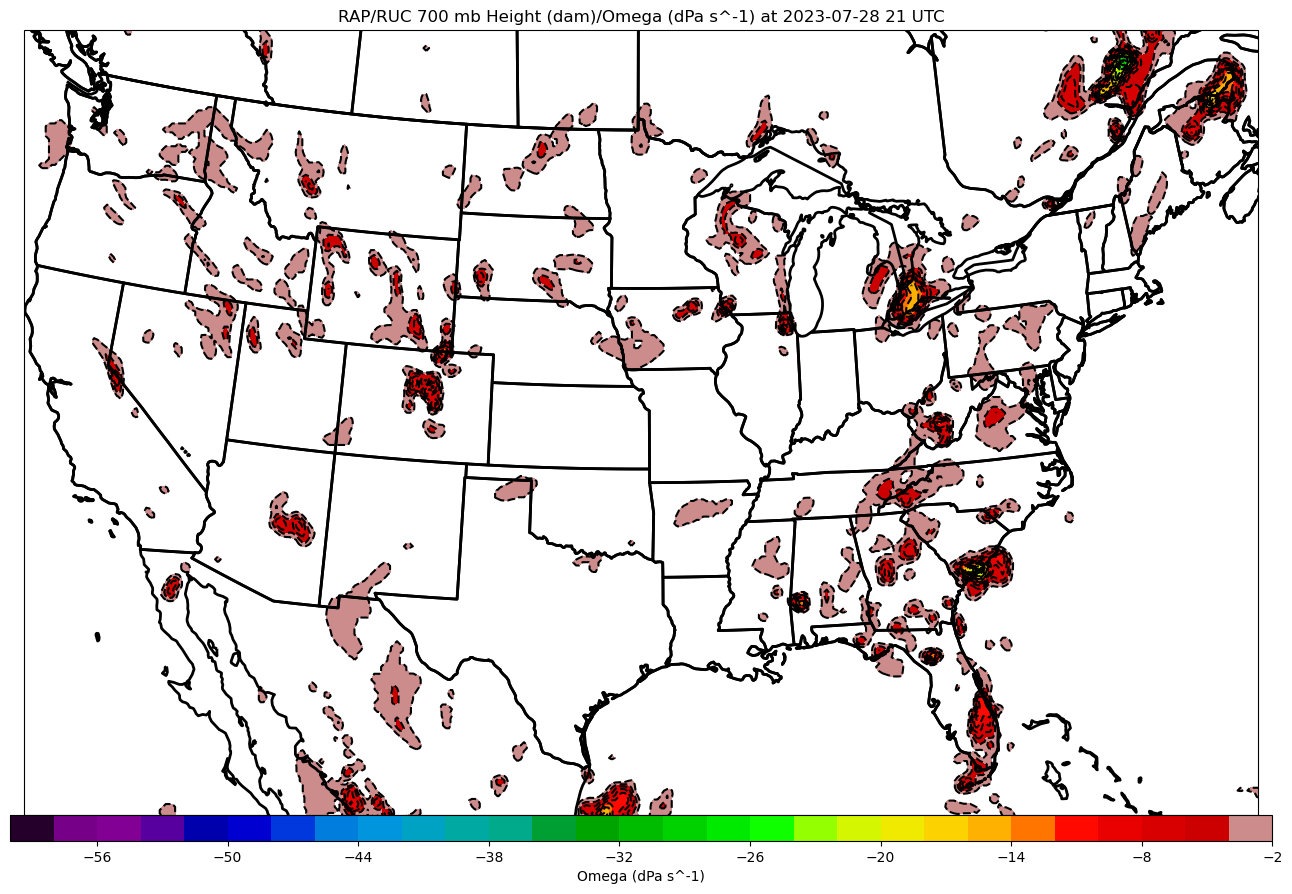

In [18]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1,projection=mSLP.metpy.cartopy_crs)

#ax.set_extent([-90, -80, 40, 50])
ax.set_extent([-120, -70, 50, 22])


ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=2, zorder=2)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=2)

omega_fill = ax.contourf(ds.x, ds.y, uvv, cmap = 'nipy_spectral', levels = np.arange(-60, 0, 2), zorder=1)
plt.colorbar(omega_fill,orientation='horizontal',pad=0.0, aspect=50, label='Omega (dPa s^-1)', ax = ax , shrink = 0.905 )
ax.contour(ds.x, ds.y, uvv, levels = np.arange(-60, 0, 2), colors='black', zorder=1)
#plt.title(f'RAP 500MB: Total Deformation and Streamlines {formatted_time}', loc='left')
ax.set_title(f'RAP/RUC 700 mb Height (dam)/Omega (dPa s^-1) at {year}-{month}-{day} {hour_utc} UTC', fontsize = 12)
#ax.streamplot(x, y, u, v, color='black', zorder=1, arrowstyle='->', density=2, linewidth=2)
plt.show()